# Setup

In [16]:
import torchvision.transforms as tfs
import einops
from src.models.utils import download_checkpoint, load_model
from src.experiments import *
from src.experiments.utils import *
from src.visualization import *
from src.optimization import *
from IPython.display import Image 
from PIL import Image
from src.optimization.optimizers import NormalizedOptimizer

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
checkpoint_path = download_checkpoint("https://drive.google.com/file/d/19m_SaRNEF7JXHjeyNu26AxgaEQXqpI00", "protopnet.pt")
model = load_model('protopnet', checkpoint_path, device=device)

In [19]:
img_size = 224
size = (3, img_size, img_size)

transforms = [ClampingMinMax(0, 1)]
parametrization_transforms = [NormalizationMeanStd()]
denormalization_transforms = [DenormalizationMeanStd()]
gradient_transforms = [tfs.GaussianBlur(7, 2)]
to_tensor = tfs.Compose([tfs.Resize(size=(img_size, img_size)),tfs.ToTensor()])

In [20]:
loss_agg_fn = AggregationFn(metric="similarity").to(device)

In [21]:
def vis(ptypes, name, lr_scheduler_cls=None, lr_scheduler_kwargs={}, robustness_transforms=[]):
    input_image = Image.open(f"data/train_cropped/{name}")

    display(input_image)
    
    input_tensor = to_tensor(input_image)
    input_tensor = einops.repeat(input_tensor.unsqueeze(0), 'pic x y z-> (repeat pic) x y z', repeat=3)
    
    #input_tensor = torch.rand((3, 3, img_size, img_size))
    images = visualize_prototypes(model, 
                             ptypes,
                            optimization_steps=200, 
                            input_tensor=input_tensor.clone(),
                            transforms=transforms, 
                            robustness_transforms=robustness_transforms,
                            parametrization_transforms=parametrization_transforms,
                            denormalization_transforms=denormalization_transforms,
                            gradient_transforms=gradient_transforms,
                            optimizer_kwargs={"lr": 0.02},
                            lr_scheduler_cls=lr_scheduler_cls,
                            lr_scheduler_kwargs=lr_scheduler_kwargs,
                            lr_scheduler_step_interval=10,
                            print_interval=200,
                            display_interval=200)
    for img in images:
        pilimg = tfs.ToPILImage()(img)
        display(pilimg)
        
    return pilimg

In [22]:
from torch.optim.lr_scheduler import MultiplicativeLR, SequentialLR
lr_scheduler_cls = MultiplicativeLR
lr_scheduler_kwargs = {"lr_lambda": lambda itr: 1.2 if itr < 10 else 0.95}

# Example

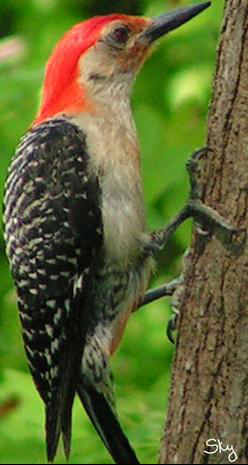

step: 0/200, loss: 7.483745098114014, lr: 0.02


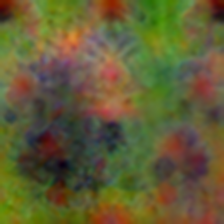

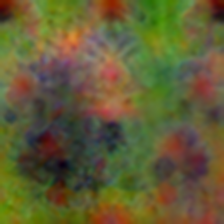

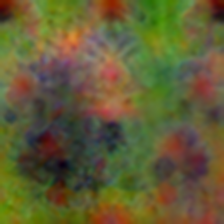

In [23]:
image_name = "189.Red_bellied_Woodpecker/Red_Bellied_Woodpecker_0002_180879.jpg"
out_image = vis([(188,1)],image_name,lr_scheduler_cls, lr_scheduler_kwargs, [tfs.GaussianBlur(7, 2),ReversibleRandomHorizontalFlip(p=0.5)])
# heatmap(model, out_image, 188, 0, superimpose=False)